In [11]:
# LangChain
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.graphs import Neo4jGraph
from langchain_core.tools import tool
from langchain_groq import ChatGroq

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# LangSmith
from langsmith import traceable

# General Imports
import os
import ast
import operator
from pathlib import Path
from prompts import personality_scientist_prompt, extractor_prompt, recommender_prompt
from dotenv import load_dotenv
from typing import TypedDict, Annotated # to construct the agent's state
from IPython.display import Image, display

# Connect to graph
dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)
os.environ["NEO4J_URI"] = os.getenv('uri')
os.environ["NEO4J_USERNAME"] = os.getenv('user_name')
os.environ["NEO4J_PASSWORD"] = os.getenv('password')
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv('LANGCHAIN_TRACING_V2')
graph = Neo4jGraph()

# Create the tool to be used by the Agent
@tool
def query_graph(query):
  """Query from Neo4j knowledge graph using Cypher."""
  return graph.query(query)


# Create Agent's State
class AgentState(TypedDict):
    conversation: Annotated[list[ AnyMessage ], operator.add]
    tool_messages: Annotated[list[ list[AnyMessage] ], operator.add]
    cypher_code_and_query_outputs: Annotated[list[ dict ], operator.add]
    extracted_data: Annotated[list[str], operator.add]

# Create Agent
class Agent:

    def __init__(self, model, tools, system):
        self.system = system
        self.tools = {t.name: t for t in tools} # Save the tools' names that can be used
        self.model = model.bind_tools(tools) # Provide the name of the tools to the agent

        graph = StateGraph(AgentState) # Initialize a stateful graph
        memory = MemorySaver()

        graph.add_node("personality_scientist", self.call_groq) # LLM node
        graph.add_node("toolbox", self.use_tool) # Use tool(query graph) called by the previous message
        graph.add_node("structure_queried_data", self.structure_queried_data)
        graph.add_node("extract_data", self.extract_data) # Extract data from last query
        graph.add_node("recommend_careers", self.recommend_careers)

        ## Create edges
        graph.add_conditional_edges("personality_scientist", self.validate_tool_call, {True: "toolbox", False: END})
        graph.add_edge("toolbox", "structure_queried_data")
        graph.add_edge("structure_queried_data", "extract_data")
        graph.add_edge("extract_data", "recommend_careers")
        graph.add_edge("recommend_careers", END)
        graph.set_entry_point("personality_scientist")

        # Build graph
        self.graph = graph.compile(checkpointer=memory)
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    ## Get the LLM's response and update the Agent's State by adding the response to the messages
    @traceable
    def call_groq(self, state: AgentState):
        messages = state['conversation']
        
        if self.system: 
            conversation = [SystemMessage(content=self.system)] + messages
        
        ai_response = self.model.invoke(conversation)
        return {'conversation': [ai_response]}
    
    ## Check if the model called for an action by checking the last message in the conversation
    def validate_tool_call(self, state: AgentState):
        ai_message = state['conversation'][-1]
        return len(ai_message.tool_calls) > 0

    ## Search for the called tools and use it
    def use_tool(self, state: AgentState):
        
        tool_calls = state['conversation'][-1].tool_calls
        results = []
        
        for tool in tool_calls:
            print(f"Calling: {tool}")

            # If tool not found
            if not tool['name'] in self.tools: 
                print("\n ....tool name not found in list of tools....")
                result = "tool name was not found in the list of tools, retry"  # instruct LLM to retry
            
            # If tool exists, use it
            else:
                try:
                    result = self.tools[tool['name']].invoke(tool['args'])
                except ValueError as e: # If written cypher code is wrong
                    result = f"ValueError occurred: {str(e)}"

            # Save the message returned from the tool
            results.append(ToolMessage(tool_call_id=tool['id'], name=tool['name'], content=str(result)))

        print("Back to the model!")
        return {'tool_messages': [results]}
    
    ## Organize the tool's output as: {'cypher_code': Cypher code, 'output': Query output}
    def structure_queried_data(self, state: AgentState):
        
        tool_calls = state['conversation'][-1].additional_kwargs['tool_calls'] # returns a list of dictionaries
        query_output = state['tool_messages'][-1] # returns a list of tool messages

        structured_outputs = []
        for i in range(len(tool_calls)):
            cypher_code = ast.literal_eval(tool_calls[i]['function']['arguments'])['query']
            output = query_output[i].content
            
            if cypher_code:
                structured_outputs.append({'cypher_code': cypher_code, 'output': output})

        return {'cypher_code_and_query_outputs': structured_outputs}
    
    ## Model extracts whatever it needs from the queried data
    def extract_data(self, state: AgentState):
        
        # Prepare data to give it to the model
        # NOTE: cypher_code_and_query_outputs has individual queries with their respective outputs. Here I am looping over the last (n) number of returned tool messages and grouping together to give them to the model, because the model can call the tool multiple times and return multiple tool messages. So, I check the number of tool calls (n) and use it as the number of times to loop over the last cypher_code_and_query_outputs.
        queried_data = []
        last_tool_message = state['tool_messages'][-1]
        for i in range(-1, -len(last_tool_message)-1, -1):
            cypher_code = state['cypher_code_and_query_outputs'][i]['cypher_code']
            output = state['cypher_code_and_query_outputs'][i]['output']
            queried_data.append(f"cypher code: {cypher_code}. output: {output}")
            
        # Give the model the conversation history and the queried data
        prompt = [SystemMessage(content=self.system)] + state['conversation'] + [HumanMessage(content= extractor_prompt.format(queried_data=queried_data))]

        extracted_data = self.model.invoke(prompt)
        return {"extracted_data": [extracted_data.content]}

    ##
    def recommend_careers(self, state: AgentState):
        prompt = [SystemMessage(content=self.system)] + state['conversation']
        prompt = prompt + [HumanMessage(content= recommender_prompt.format(extracted_data=state['extracted_data']))]
        
        recommended_careers = self.model.invoke(prompt)
        return {'conversation': [recommended_careers]}

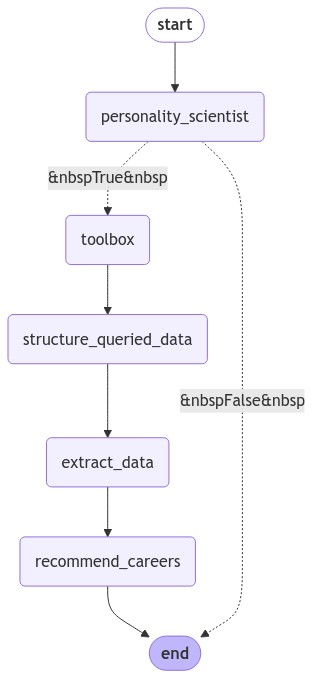

In [12]:
model = ChatGroq(temperature=0.8, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama-3.1-70b-versatile")

agent = Agent(model=model, tools=[query_graph], system=personality_scientist_prompt.format(schema=graph.structured_schema))

In [30]:
thread = {'configurable': {'thread_id': "1"}}
output = agent.graph.stream({"conversation": [HumanMessage(content="I prefer any environment as long as Im talking and listening to people, also I like to work with troubled people.")]}, thread, stream_mode='values')

for message in output:
    message['conversation'][-1].pretty_print()

================================ Human Message =================================

I prefer any environment as long as Im talking and listening to people, also I like to work with troubled people.
================================== Ai Message ==================================
Tool Calls:
  query_graph (call_h6vs)
 Call ID: call_h6vs
  Args:
    query: MATCH (n:Occupation)-[]->(m:Personality_Trait) WHERE m.title =~ '.*Social.*' RETURN n,m
Calling: {'name': 'query_graph', 'args': {'query': "MATCH (n:Occupation)-[]->(m:Personality_Trait) WHERE m.title =~ '.*Social.*' RETURN n,m"}, 'id': 'call_h6vs', 'type': 'tool_call'}
Back to the model!
================================== Ai Message ==================================
Tool Calls:
  query_graph (call_h6vs)
 Call ID: call_h6vs
  Args:
    query: MATCH (n:Occupation)-[]->(m:Personality_Trait) WHERE m.title =~ '.*Social.*' RETURN n,m
================================== Ai Message ==================================
Tool Calls:
  query_graph (ca

In [37]:
state = agent.graph.get_state(thread).values


len(state['tool_messages'][-1]), len(state['cypher_code_and_query_outputs'])
state['cypher_code_and_query_outputs']
print(state['conversation'][-1].content)

Based on your preference for working with troubled people and enjoying talking and listening to others, combined with the extracted data, here are some suitable career tracks that might interest you:

* **Psychiatric Aides**: This role involves working with people who have mental illnesses or disabilities, which aligns with your interest in helping troubled individuals. Your social skills will be valuable in this role, and you'll have the opportunity to make a positive impact on people's lives.
* **Hearing Aid Specialists**: While this role may not seem directly related to working with troubled people, it can be very rewarding to help individuals with hearing impairments. Your social skills will be essential in communicating with clients and understanding their needs.
* **Emergency Medical Technicians (EMTs)**: As an EMT, you'll work with people in emergency situations, which can be challenging but also very rewarding. Your social skills will help you communicate effectively with patie

In [ ]:
def extract_labels_from_query(cypher_code):
  # Extract start index and end index of the labels example: (n:Occupation) => start is ( end is )
  start = []
  end = []
  for i, character in enumerate(cypher_code):
    if character == "(": start.append(i+1)
    if character == ")": end.append(i)

  # Extract the labels using the start and end indicies. return labels as {'n': 'Occupation'...}
  labels = {}
  for i in range(len(start)):
    label = cypher_code[start[i]: end[i]] # returns "n:Occupation"
    label = label.split(":") # returns ["n", "Occupation"]

    labels[label[0]] = label[1]

  return labels


def organize_queried_data(data, labels):
  structured_queried_data = {'labels': list(labels.values()), 'relations': []}

  for i in range(len(data)):
    # extract keys (nodes' refrences as they were returned from the query's output. example: "cypher code ... return n,m")
    row = data[i]
    keys = list(row.keys()) # keys are the referenced labels. example: n:Occupation, so n is referencing Occupation
    
    # Extract node relations. example: Occupation: Teacher, Personality_Trait: Social
    
    relation = []
    for i in range(len(keys)):
      key = keys[i]
      # label = labels[key]
      properties = row[key]
      
      relation.append(properties)

    structured_queried_data['relations'] += [relation]
  
  return structured_queried_data

query_output = ast.literal_eval(state['cypher_code_and_query_outputs'][0]['output'])
llm_query = state['cypher_code_and_query_outputs'][0]['cypher_code']

labels = extract_labels_from_query(cypher_code=llm_query)
outputs = organize_queried_data(data=query_output, labels=labels)
outputs